<a href="https://colab.research.google.com/github/Xinyuan-wur/or-tools/blob/master/BayesianBWM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Execution guide
To execute each cell, press **SHIFT + ENTER**!



In [ ]:
!pip install jax==0.2.13
!pip install jaxlib==0.1.65
!pip install numpyro==0.7.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.4/630.4 kB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jax: filename=jax-0.2.13-py3-none-any.whl size=730500 sha256=565601e940587e0ab3d77012f055d3f4ac848e195e27abec112a32a6a0043672
  Stored in directory: /root/.cache/pip/wheels/21/23/be/731e489df7966ccbdaece01c64391a6dd9d03fb7f394eb48b2
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.4.8
    Uninstalling jax-0.4.8:
      Successfully uninstalled jax-0.4.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires jax>=0.3.15, but you have jax 0.2.13 which is incompatible.
orbax-checkpoint 0.2.1 requires jax>=0.4.8, but you have jax 0.2.13 which is incompatible.
flax 0.6.9

# This section includes the required libraries for executing the Bayesian BWM


In [ ]:
import numpy as np
import numpyro
from numpyro.infer import MCMC, NUTS, HMC
import numpyro.distributions as dist
from jax import random


ImportError: ignored

#Main functions
This section includes the main functions required for executing the Bayesian BWM:


1.   **PyroModelBayesianBWM**: The function that specifies the probabilistic model with the Numpyro library
2.   **BayesianBWM**: The main function that takes as inputs two matrices of Best-to-Others and Others-to-Worst of all decision-makers, and return the aggregated weights

3. **Credal Ranking**: This function visualizes the weighted directed graph for the credal ranking

Please **DO NOT CHANGE** these functions when you copy the code for yourself!



In [ ]:
##################### The Numpyro model for Bayesian BWM
def PyroModelBayesianBWM(a_b,a_w):
    aw_tc = np.sum(a_w, axis=1)
    ab_tc = np.sum(a_b, axis=1)
    dm_no, c_no = a_w.shape 
    w_star = numpyro.sample("wStar", dist.Dirichlet(0.01*np.ones(c_no)))
    gamma_star = numpyro.sample("gammaStar", dist.Gamma(0.01, 0.01))
    
    with numpyro.plate("dm_i", dm_no):
        w = numpyro.sample("w", dist.Dirichlet(gamma_star*w_star))

        inv_w = 1 / w
        inv_w /= np.sum(inv_w)
        numpyro.sample('a_w',dist.Multinomial(probs=w, total_count=aw_tc), obs=a_w)
        numpyro.sample('a_b',dist.Multinomial(probs=inv_w, total_count=ab_tc), obs=a_b)


##################### Bayesian BWM main function
def BayesianBWM(ab,aw):
  HMC_kernel = HMC(PyroModelBayesianBWM)

  numpyro.set_host_device_count(4)

  mcmc = MCMC(HMC_kernel, num_samples=5000, num_warmup=2000, num_chains=3, chain_method='parallel')
  rng_key = random.PRNGKey(0)
  mcmc.run(rng_key, ab, aw)

  posterior_samples = mcmc.get_samples()

  return posterior_samples["wStar"], posterior_samples['w']


##################### Visualization of credal ranking
def CredalRanking(wStar, criteria_name):
  import math
  import networkx as nx
  import matplotlib.pyplot as plt
  from matplotlib.colors import Normalize
  import seaborn as sns
  import matplotlib.cm as cmx


  def roundUp(n, d=2):
      d = int('1' + ('0' * d))
      return math.ceil(n * d) / d

  # np.mean(w_star,axis=0)
  n_c = wStar.shape[1]
  w = np.zeros((n_c, n_c))

  for i in range(n_c):
    for j in range(i+1, n_c):
      w_ij = np.sum(wStar[:,i] > wStar[:,j])
      w_ji = np.sum(wStar[:,i] < wStar[:,j])
      if w_ij > w_ji:
        w[i,j] = roundUp((w_ij / wStar.shape[0]), 2)
      else:
        w[j,i] = roundUp((w_ji / wStar.shape[0]), 2)


  colors = sns.color_palette(None, n_c)

  plt.figure(figsize=(12,12))

  # Create DiGraph from w
  G = nx.convert_matrix.from_numpy_array(w, create_using=nx.DiGraph)

  # Use spring_layout to handle positioning of graph
  layout = nx.kamada_kawai_layout(G)


  # Color mapping
  colors = plt.cm.jet #sns.color_palette(None, n_c)
  cNorm  = Normalize(vmin=0, vmax=n_c-1)
  scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colors)
  values = [node for node in G.nodes()]

  # Using a figure to use it as a parameter when calling nx.draw_networkx
  f = plt.figure(1)
  ax = f.add_subplot(1,1,1)
  for label in criteria_name:
      ax.plot([0],[0],color=scalarMap.to_rgba(criteria_name[label]),label=label)

  # Draw the graph using the layout
  nx.draw(G, layout, with_labels=True, node_size=2000, edgecolors='black', node_color=values,ax=ax)

  # Get weights of each edge and assign to labels
  labels = nx.get_edge_attributes(G, "weight")

  # Draw edge labels using layout and list of labels
  nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)

  # Setting it to how it was looking before.                                                                                                              
  plt.axis('off')
  f.set_facecolor('w')

  plt.legend()

  f.tight_layout()
  plt.show()
  



#Example Execution:

Define two arrays with the same size, one for Best-to-Others (A_B) and one for Others-to-Worst (A_W). Each row in these matrices corresponds to the preferences of a decision-maker!

Also, specify the name of criteria for visualizing the credal ranking!

In [ ]:
A_B =  np.array([
       [3, 4, 6, 1, 5, 2, 9, 7],
       [1, 2, 8, 4, 5, 3, 9, 6],
       [2, 2, 3, 1, 5, 5, 9, 8],
       [2, 1, 8, 2, 9, 3, 8, 8],
       [2, 4, 9, 1, 4, 3, 5, 5],
       [1, 2, 9, 1, 3, 5, 5, 4]])

A_W =  np.array([
      [ 7, 6, 4, 9, 5, 8, 1, 3],
      [ 9, 8, 2, 5, 4, 5, 1, 3],
      [ 8, 8, 5, 9, 5, 5, 1, 2],
      [ 8, 9, 2, 8, 1, 8, 2, 2],
      [ 8, 6, 1, 9, 6, 7, 4, 4],
      [ 9, 8, 1, 9, 7, 5, 5, 6]]) 

criteria_name = {'Cost of delivery': 0, 'Lead time':1, 'Non-competitor':2, 'Price':3,'Production fac.':4, 'Quality':5, 'Compliance':6, 'Sus. per':7}

wStar, w = BayesianBWM(A_B,A_W)

print('The average of the aggregated weight distribution is:', np.mean(wStar,axis=0))

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

The average of the aggregated weight distribution is: [0.19783044 0.17374106 0.06211958 0.19996779 0.09490573 0.13894612
 0.05917217 0.07331711]


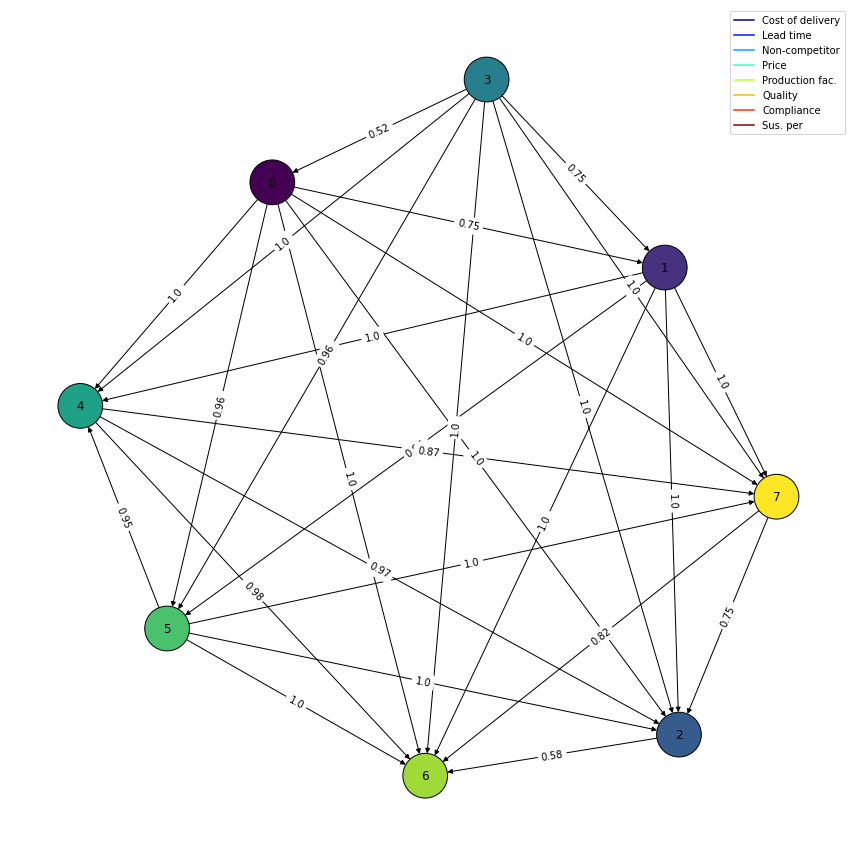

In [ ]:
CredalRanking(wStar, criteria_name)